## Week 2 HW: Missing Data and Smoothing Models
### Jingwen Li

In [32]:
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from sktime.forecasting.all import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import seaborn as sns
import random
from pandas.tseries.offsets import BDay
import warnings
warnings.filterwarnings("ignore")

In [33]:
data = pd.read_csv('hw2_data.csv', index_col=0, parse_dates=True)
data

,IWM,QQQ,SPY
Date,,,
2000-05-26,34.800865,67.670738,93.363678
2000-05-30,NaN,NaN,NaN
2000-05-31,NaN,NaN,NaN
2000-06-01,37.036850,76.048004,98.310966
2000-06-02,38.963646,81.487755,100.023491
...,...,...,...
2020-02-26,152.328430,215.254486,305.789459
2020-02-27,146.964890,204.475845,292.055939
2020-02-28,NaN,NaN,NaN


## Part 1 - Exploratory Data Analysis

### 1. Plot the data

<AxesSubplot: xlabel='Date'>

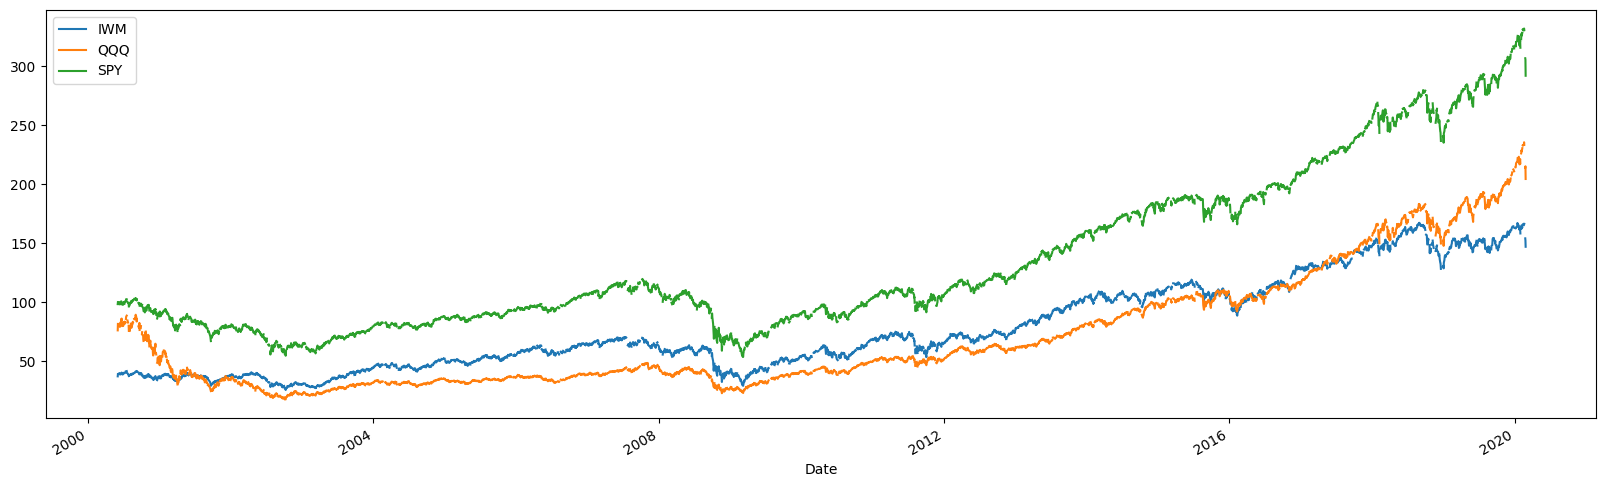

In [34]:
data.plot(figsize=(20, 6))

### 2. From looking at the plot, does there appear to be missing data?

From looking at the plot, I can spot some inconsistency , it appears there are some missing data from time to time.

### 3. How many NA values appear in each time series? What percentage of data is missing? Give one reason why we might be missing data in this pattern?

- How many NAs?

In [35]:
data.isna().sum()

IWM    897
QQQ    897
SPY    897
dtype: int64

- What percentage?

In [36]:
data.isna().sum()/data.shape[0]

IWM    0.18041
QQQ    0.18041
SPY    0.18041
dtype: float64

- Reason:

As shown below, all the dates reported in this dataset are trading days which rules out the reason of dates being non-trading days, so possible reason for this could be data processing issues such as: systematic data errors, data transformation or manipulation, sampling and aggregation and etc.

In [37]:
# Create DatetimeIndex of all business days in range of data
all_days = pd.bdate_range(start=data.index.min(), end=data.index.max(), freq=BDay())

# Create boolean mask for trading days
is_trading_day = data.index.isin(all_days)

# Add column to data indicating if it's a trading day
data['is_trading_day'] = is_trading_day

data

,IWM,QQQ,SPY,is_trading_day
Date,,,,
2000-05-26,34.800865,67.670738,93.363678,True
2000-05-30,NaN,NaN,NaN,True
2000-05-31,NaN,NaN,NaN,True
2000-06-01,37.036850,76.048004,98.310966,True
2000-06-02,38.963646,81.487755,100.023491,True
...,...,...,...,...
2020-02-26,152.328430,215.254486,305.789459,True
2020-02-27,146.964890,204.475845,292.055939,True
2020-02-28,NaN,NaN,NaN,True


In [38]:
sum(data['is_trading_day'] == False)

0

### 4. Describe one business case where you would not proceed with this much missing data. Describe one business case where you would proceed with this much missing data.

- Case to not proceed

I would not proceed with this much missing data is in the development of financial models. The missing data can have a significant impact on the accuracy and reliability of the model's results, which could cause serious business loss.

- Case to proceed

I may proceed with this much missing data is in the field of market research. In these cases, missing data is a common occurrence, and we can use various methods such as imputation techniques to estimate missing data or remove incomplete data points. 

## Part 2 - Missing Data

In [39]:
data = pd.read_csv('hw2_data.csv', index_col=0, parse_dates=True)
data

,IWM,QQQ,SPY
Date,,,
2000-05-26,34.800865,67.670738,93.363678
2000-05-30,NaN,NaN,NaN
2000-05-31,NaN,NaN,NaN
2000-06-01,37.036850,76.048004,98.310966
2000-06-02,38.963646,81.487755,100.023491
...,...,...,...
2020-02-26,152.328430,215.254486,305.789459
2020-02-27,146.964890,204.475845,292.055939
2020-02-28,NaN,NaN,NaN


### 1. Create a forward fill

In [40]:
data_ffill = data.fillna(method='ffill')
data_ffill

,IWM,QQQ,SPY
Date,,,
2000-05-26,34.800865,67.670738,93.363678
2000-05-30,34.800865,67.670738,93.363678
2000-05-31,34.800865,67.670738,93.363678
2000-06-01,37.036850,76.048004,98.310966
2000-06-02,38.963646,81.487755,100.023491
...,...,...,...
2020-02-26,152.328430,215.254486,305.789459
2020-02-27,146.964890,204.475845,292.055939
2020-02-28,146.964890,204.475845,292.055939


### 2. Create a backward fill

In [41]:
data_bfill = data.fillna(method='bfill')
data_bfill

,IWM,QQQ,SPY
Date,,,
2000-05-26,34.800865,67.670738,93.363678
2000-05-30,37.036850,76.048004,98.310966
2000-05-31,37.036850,76.048004,98.310966
2000-06-01,37.036850,76.048004,98.310966
2000-06-02,38.963646,81.487755,100.023491
...,...,...,...
2020-02-26,152.328430,215.254486,305.789459
2020-02-27,146.964890,204.475845,292.055939
2020-02-28,NaN,NaN,NaN


### 3. Create a moving average fill

In [42]:
data_MAfill = data.fillna(data.rolling(10, min_periods=1).mean())
data_MAfill

,IWM,QQQ,SPY
Date,,,
2000-05-26,34.800865,67.670738,93.363678
2000-05-30,34.800865,67.670738,93.363678
2000-05-31,34.800865,67.670738,93.363678
2000-06-01,37.036850,76.048004,98.310966
2000-06-02,38.963646,81.487755,100.023491
...,...,...,...
2020-02-26,152.328430,215.254486,305.789459
2020-02-27,146.964890,204.475845,292.055939
2020-02-28,159.514550,224.240459,318.520272


### 4. Create an interpolation

In [43]:
data_interpolated = data.interpolate(method='linear')
data_interpolated

,IWM,QQQ,SPY
Date,,,
2000-05-26,34.800865,67.670738,93.363678
2000-05-30,35.546193,70.463160,95.012774
2000-05-31,36.291522,73.255582,96.661870
2000-06-01,37.036850,76.048004,98.310966
2000-06-02,38.963646,81.487755,100.023491
...,...,...,...
2020-02-26,152.328430,215.254486,305.789459
2020-02-27,146.964890,204.475845,292.055939
2020-02-28,146.964890,204.475845,292.055939


## Part 3 - Smoothing Methods (statsmodels)

- I choose Interpolation

In [52]:
SPY = data_interpolated['SPY'].to_frame()
SPY

,SPY
Date,
2000-05-26,93.363678
2000-05-30,95.012774
2000-05-31,96.661870
2000-06-01,98.310966
2000-06-02,100.023491
...,...
2020-02-26,305.789459
2020-02-27,292.055939
2020-02-28,292.055939


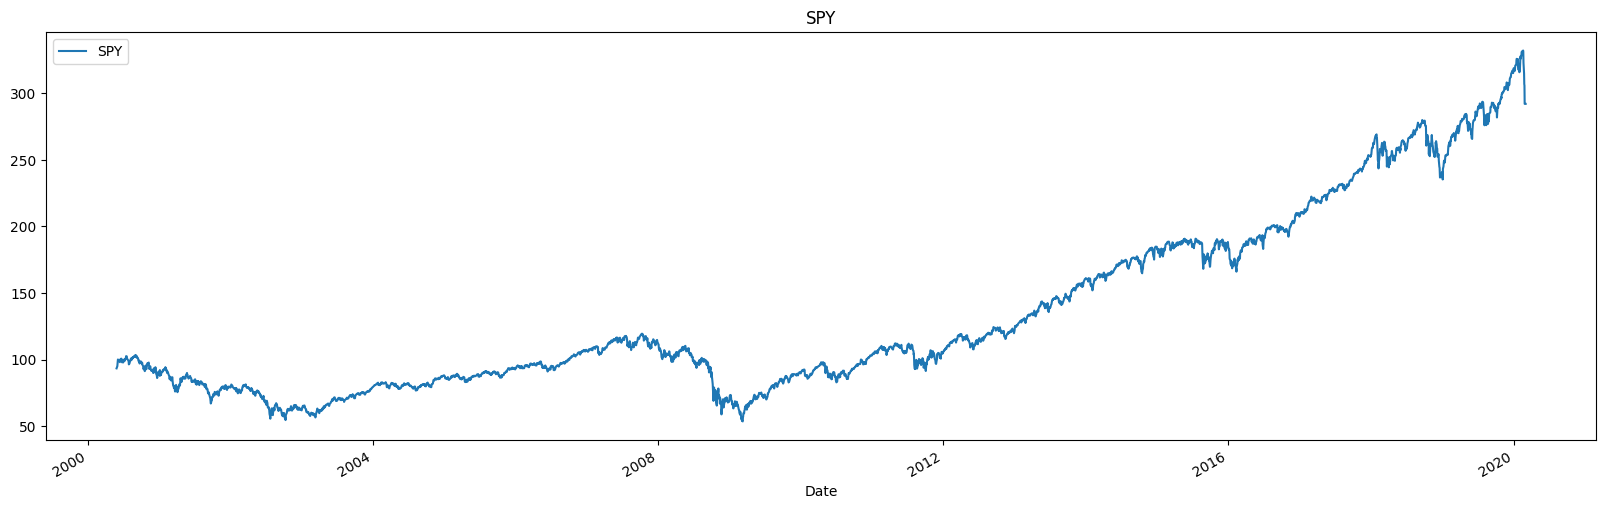

In [53]:
SPY.plot(title='SPY',figsize=(20, 6))
plt.show()

- Split using temporal train and test.

In [54]:
y_train, y_test = temporal_train_test_split(SPY)

In [55]:
y_train.shape

(3729, 1)

In [56]:
y_test.shape

(1243, 1)

- Use a for loop or create a function to avoid repetitive code

In [78]:
def smoothing_func(df_train, df_test, trend = None, seasonal_periods = None, seasonal = None):
    fit = ExponentialSmoothing(df_train, trend = trend, seasonal_periods = seasonal_periods, seasonal = seasonal).fit()
    pred = fit.forecast(len(df_test))
    return fit, pred

In [79]:
def display_func(df_train, df_test, fit, pred):
    plt.figure(figsize=(20, 6))
    plt.plot(df_train.index, df_train, label='Training Data')
    plt.plot(df_test.index, pred, label='Predictions', color='red')
    plt.plot(df_test.index, df_test, label='Testing Data', color='black')
    plt.plot(fit.fittedvalues.index, fit.fittedvalues, label='Fitted Values', color='red', linestyle='--')
    plt.legend(loc='best')
    plt.show()
    
    # Calculate smape of test set performance
    dict = {}
    dict['sampe'] = MeanAbsolutePercentageError()(df_test, pred)
    
    return dict

### 1. Simple exponential smoothing

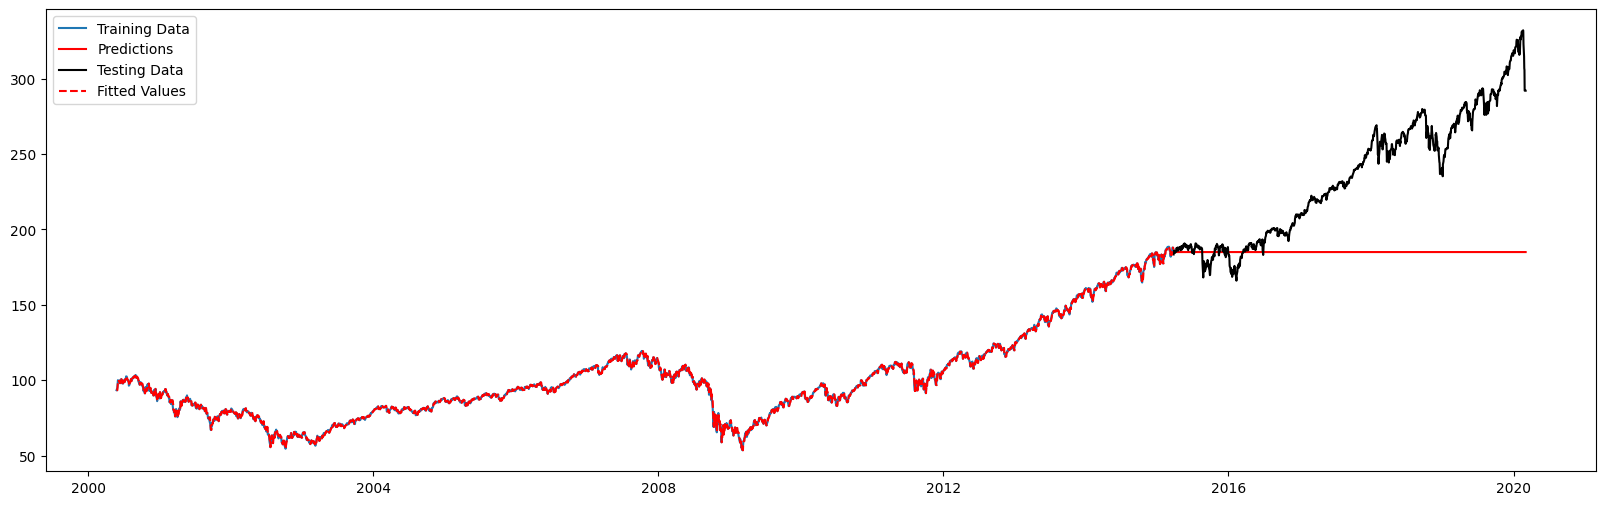

{'sampe': 0.19523632004182154}

In [80]:
fit1, y_pred1 = smoothing_func(y_train, y_test)
display_func(y_train, y_test, fit1, y_pred1)

### 2. Holt additive trend

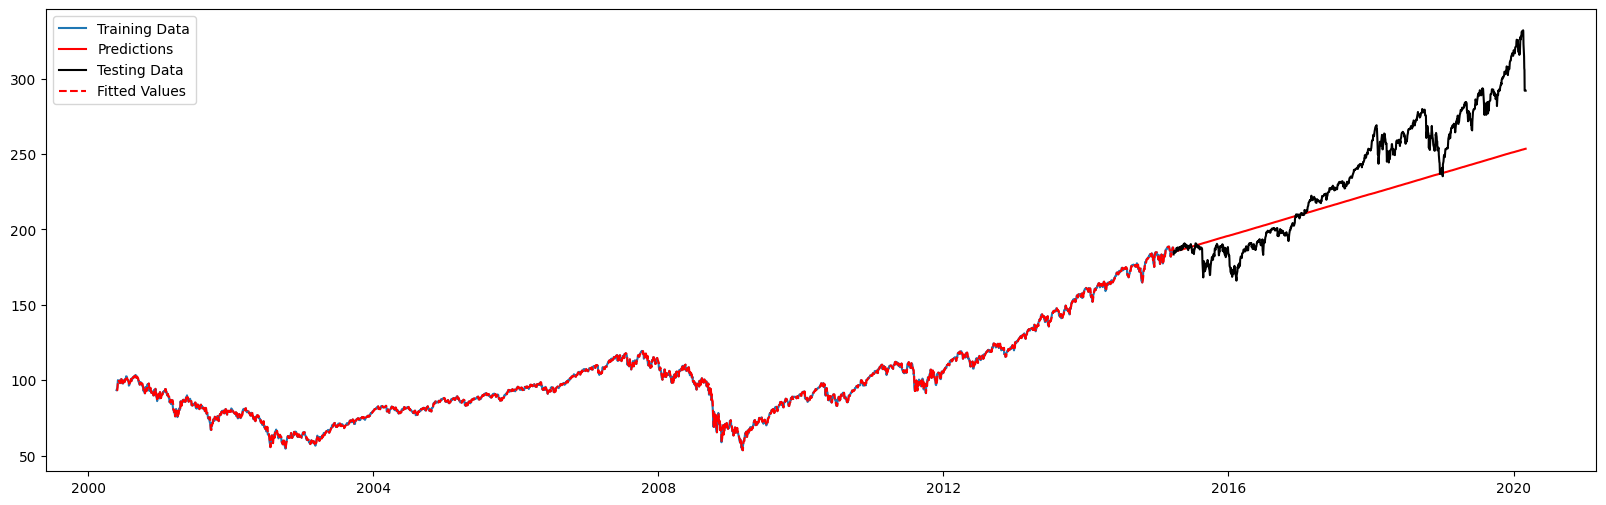

{'sampe': 0.08538124942125472}

In [81]:
fit2, y_pred2 = smoothing_func(y_train, y_test, trend = 'add')
display_func(y_train, y_test, fit2, y_pred2)

### 3. Holt multiplicative trend

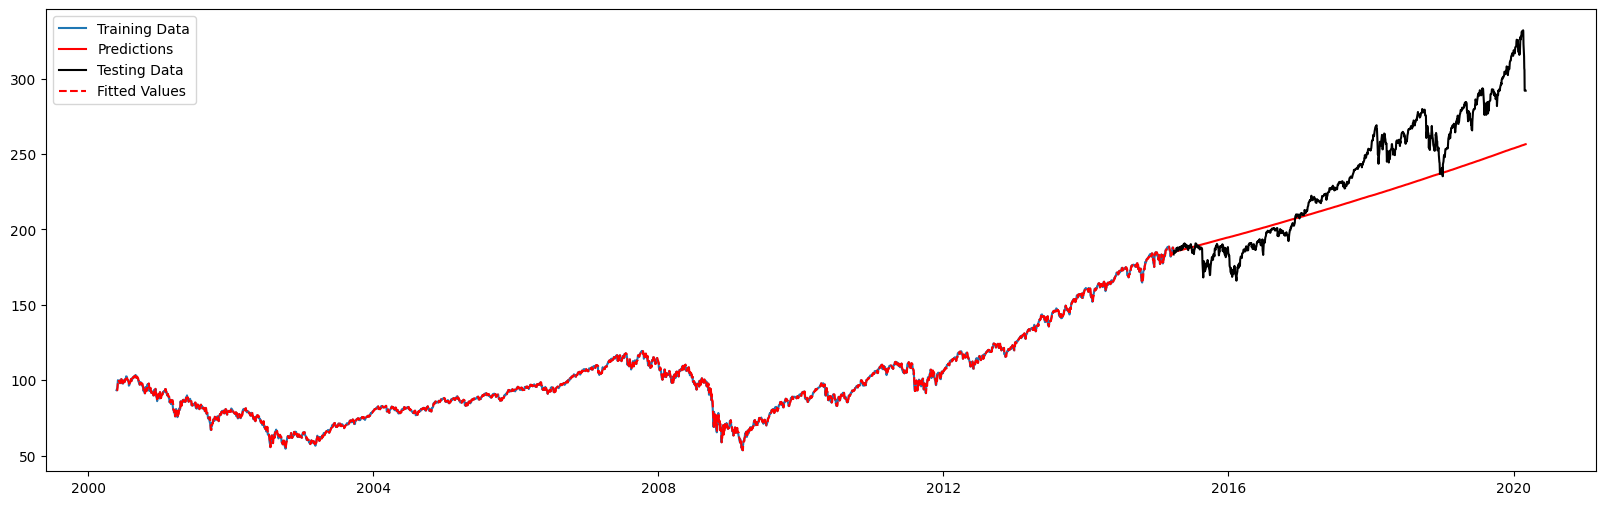

{'sampe': 0.0843029221080387}

In [82]:
fit3, y_pred3 = smoothing_func(y_train, y_test, trend='mul')
display_func(y_train, y_test, fit3, y_pred3)

### 4. Holt Winters additive trend and additive seasonality

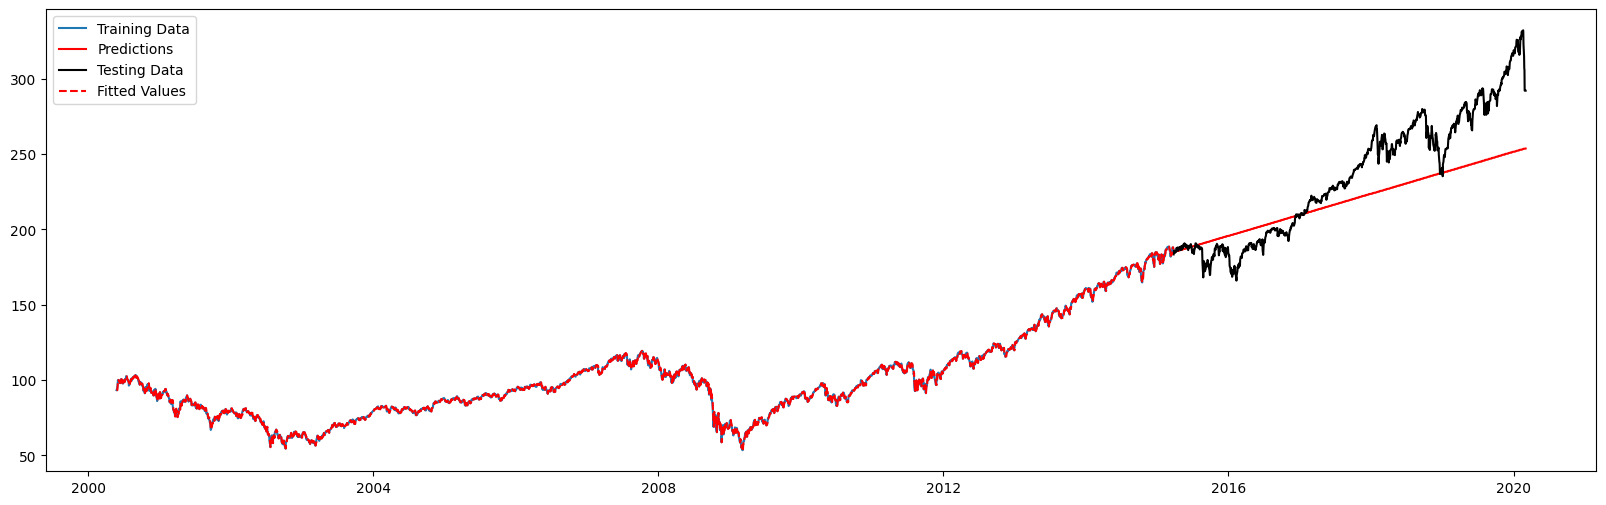

{'sampe': 0.08503271291928358}

In [83]:
fit4, y_pred4 = smoothing_func(y_train, y_test, trend='add', seasonal_periods=12, seasonal='add')
display_func(y_train, y_test, fit4, y_pred4)

### 5. Holt Winters multiplicative trend and multiplicative seasonality

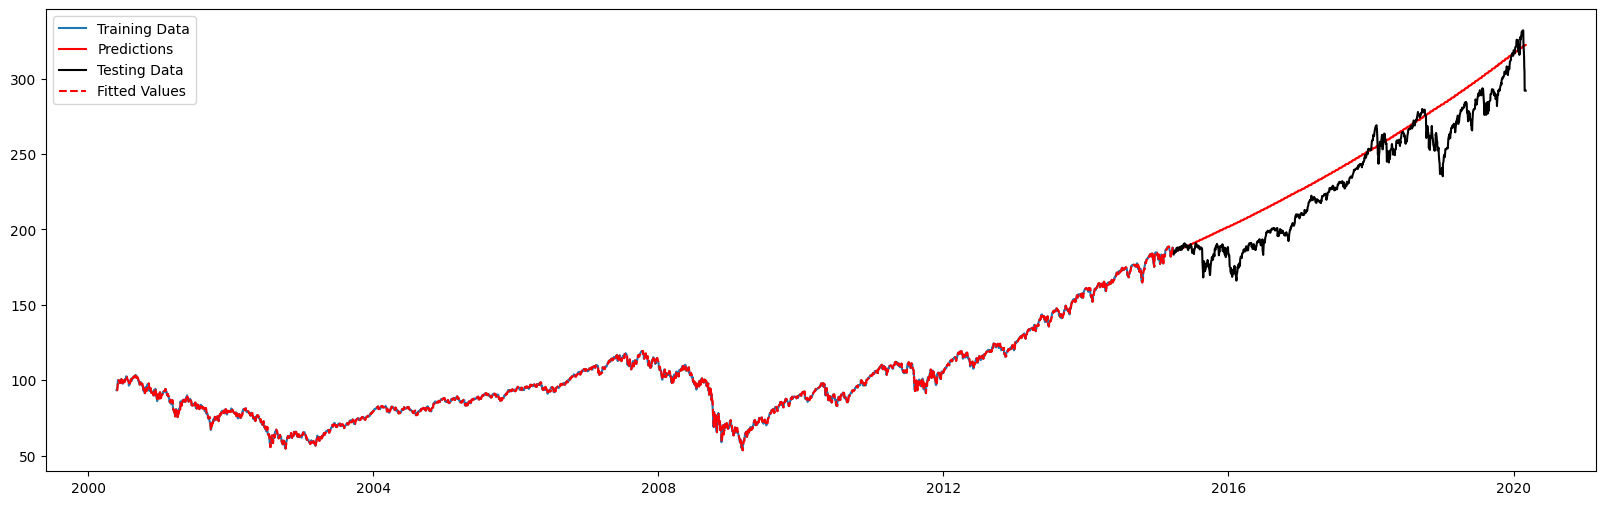

{'sampe': 0.06054501652201499}

In [84]:
fit5, y_pred5 = smoothing_func(y_train, y_test, trend='mul', seasonal_periods=12, seasonal='mul')
display_func(y_train, y_test, fit5, y_pred5)

### 6. Which is the best model, why is it working better? In general, does it make sense to model stock price data using this method?

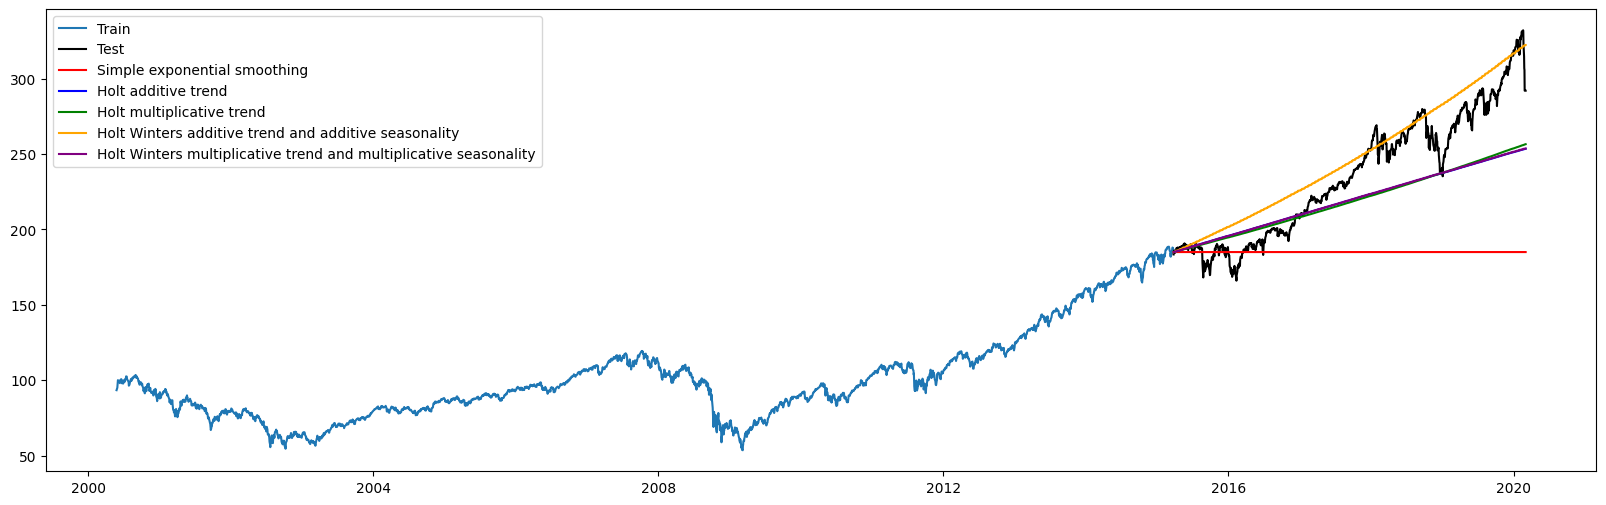

In [69]:
# Plot the values
plt.figure(figsize=(20, 6))
plt.plot(y_train.index, y_train.values, label='Train')
plt.plot(y_test.index, y_test.values, color='black', label='Test')

plt.plot(y_test.index, y_pred1.values, color='red', label='Simple exponential smoothing')
plt.plot(y_test.index, y_pred2.values, color='blue', label='Holt additive trend')
plt.plot(y_test.index, y_pred3.values, color='green', label='Holt multiplicative trend')
plt.plot(y_test.index, y_pred5.values, color='orange', label='Holt Winters additive trend and additive seasonality')
plt.plot(y_test.index, y_pred4.values, color='purple', label='Holt Winters multiplicative trend and multiplicative seasonality')

plt.legend()
plt.show()

Based on both visual check and SMAPE, Holt Winters multiplicative trend and multiplicative seasonality model works better. The Holt-Winters method assumes that the trend and seasonality components are constant over time, which may not hold for stock price data that typically exhibit non-stationary trends and irregular seasonality. Therefore, while the Holt-Winters method may work well for some time series data, it may not be suitable for modeling stock price data. Other methods such as ARIMA, GARCH, or neural networks may be more appropriate for modeling stock prices.